# Utilities

In [3]:
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import matplotlib as mpl
from scipy.integrate import odeint
from numpy import linalg as LA
from scipy.optimize import fsolve
from scipy.optimize import curve_fit
mpl.rcdefaults() 
from scipy.stats import uniform
import scipy.stats as st
from matplotlib import colors
from matplotlib import cm
import pandas as pd
import datetime
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import cartopy
import json
import xarray as xr
import pickle
from scipy.stats import linregress
from EWS_functions import *
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d

jtplot.style(context='paper', fscale=1.4, spines=True, grid=False, ticks=True,gridlines='--')

fontsize=16
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

mpl.rcParams['font.size'] = 16
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'
mpl.rcParams['axes.labelsize']= 'x-large'
mpl.rcParams['figure.facecolor']='white'

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial']
hfont = {'fontname':'Arial'}

mpl.rcParams['text.latex.preamble']= r'\usepackage{amsmath}'
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#666666']) 

## EWS functions

In [1]:
def get_EWS(time,data,trend,ws):
    linfits = []
    ps = []
    bound = ws // 2
    
    std = runstd(data - trend, ws)[bound:-bound]
    p0, p1 = np.polyfit(time[bound : -bound][:-2], std[:-2], 1)
    linfits.append([p0,p1])
    ps.append(kendall_tau_test(std[:-2], 1000, p0))
    
    ar1 = runac(data - trend, ws)[bound : -bound]
    p0, p1 = np.polyfit(time[bound : -bound][:-3], ar1[:-3], 1)
    linfits.append([p0,p1])
    ps.append(kendall_tau_test(ar1[:-2], 1000, p0))
    
    lam = run_fit_a_ar1(data-trend,ws)[bound:-bound]
    p0, p1 = np.polyfit(time[bound : -bound][:-2], lam[:-2], 1)
    linfits.append([p0,p1])
    ps.append(kendall_tau_test(lam[:-2], 1000, p0))
    
    return std, ar1, lam, linfits, ps

In [2]:
def plot_EWS(data, timess, ws=70, col='k',lbl='',alph=1,lw=1):
    bound = ws // 2
    popt, cov = curve_fit(funcfit3, timess, data, p0 = [-8.33097773e-01,  1.05507897e-02,  2.02518923e+03], maxfev = 1000000000)
    trend = funcfit3(timess, *popt)
    std, ar1, lam, linfits, ps = get_EWS(timess,data,trend,ws)

    ax1.plot(timess[bound : -bound],std,color=col,label=lbl,alpha=alph,lw=lw)
    pv = kendall_tau_test(std[:-2],1000,linfits[1][0])
    ax1.plot(timess[bound : -bound][:-2],linfits[0][0] * timess[bound : -bound][:-2] + linfits[0][1],linestyle='--',color=col,alpha=alph,lw=lw,label="p = {:.3f}".format(pv))

    ax2.plot(timess[bound : -bound],ar1,color=col,label=lbl,alpha=alph,lw=lw)
    pv = kendall_tau_test(ar1[:-2],1000,linfits[1][0])
    ax2.plot(timess[bound : -bound][:-2],linfits[1][0] * timess[bound : -bound][:-2] + linfits[1][1],linestyle='--',color=col,alpha=alph,lw=lw,label="p = {:.3f}".format(pv))

    ax3.plot(timess[bound : -bound],lam,color=col,label=lbl,alpha=alph,lw=lw)
    p0, p1, p2 = np.polyfit(timess[bound : -bound][:-2], lam[:-2], 2)
    pl0, pl1  = np.polyfit(timess[bound : -bound][:-2], lam[:-2], 1)
    pv = kendall_tau_test(lam[:-2], 1000, pl0) # precentile of 1000 fourier surrogates have a larger linear slope
#     ax3.plot(timess[bound : -bound][:-2], p0 * timess[bound : -bound][:-2]**2+p1 * timess[bound : -bound][:-2] + p2, color=col,linestyle='--',alpha=alph,lw=lw,label="p = {:.3f}".format(pv))
    ax3.plot(timess[bound : -bound][:-2], pl0 * timess[bound : -bound][:-2] + pl1, color=col,linestyle='--',alpha=alph,lw=lw,label="p = {:.3f}".format(pv))

# Get Values

In [6]:
ds = xr.open_dataset('CMIP6_amoc.nc')

In [7]:
strn26 = ds.strength_265N
strn35 = ds.strength_35N
index = ds.index

In [8]:
strn26.load()
strn35.load()
index.load()

<xarray.DataArray 'index' (models: 34, ensemble_members: 10, year: 165)>
array([[[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        ...,
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[ -9.83567818,  -9.96747804,  -9.87559962, ...,  -9.8192265 ,
          -9.53018165,  -9.60423207],
        [ -9.26724124,  -9.20765185,  -9.62124856, ..., -10.28693318,
         -10.51233848, -10.22079849],
        [ -9.45160929,  -9.45961754,  -9.54747669, ..., -10.22823318,
         -10.1423463 ,  -9.9231437 ],
...
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[ -8.9466881 ,  -9.2422324 ,  -9.27880526, ...,  -9.5742743 ,
          -9.38110113,  -9.47151629],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        ...,
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]]])
Coordinates:
  * models            (models) object 'AWI-CM-1-1-MR' ... 'SAM0-UNICON'
  * year              (year) int64 1850 1851 1852 1853 ... 2011 2012 2013 2014
  * ensemble_members  (ensemble_members) object 'r1i1p1f1' ... 'r10i1p1f1'

limit_output extension: Maximum message size of 10000 exceeded with 18219 characters

In [9]:
yrs = strn26.year.values
models = strn26.models.values
ensembs = strn26.ensemble_members.values

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


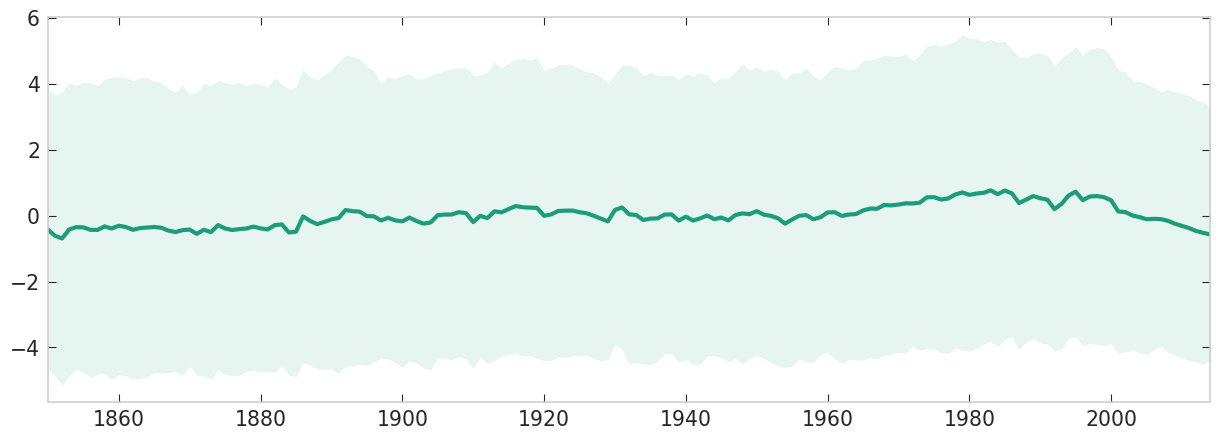

In [10]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
std = strn26.std(dim=['models','ensemble_members'])
mean = strn26.mean(dim=['models','ensemble_members'])
anomaly = mean - mean.mean(dim='year')
plt.plot(yrs,anomaly,color='C0',lw=3)
ax.fill_between(yrs,anomaly-std,anomaly+std,alpha=0.1,color='C0')
ax.set_xlim(1850,2014)
# ax.set_ylim(-2,3)
# ax2 = ax.twinx()
# std = index.std(dim=['models','ensemble_members'])
# mean = index.mean(dim=['models','ensemble_members'])
# ax2.plot(yrs,mean,color='C1',lw=3)
# ax2.fill_between(yrs,mean-std,mean+std,alpha=0.1,color='C1')

plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


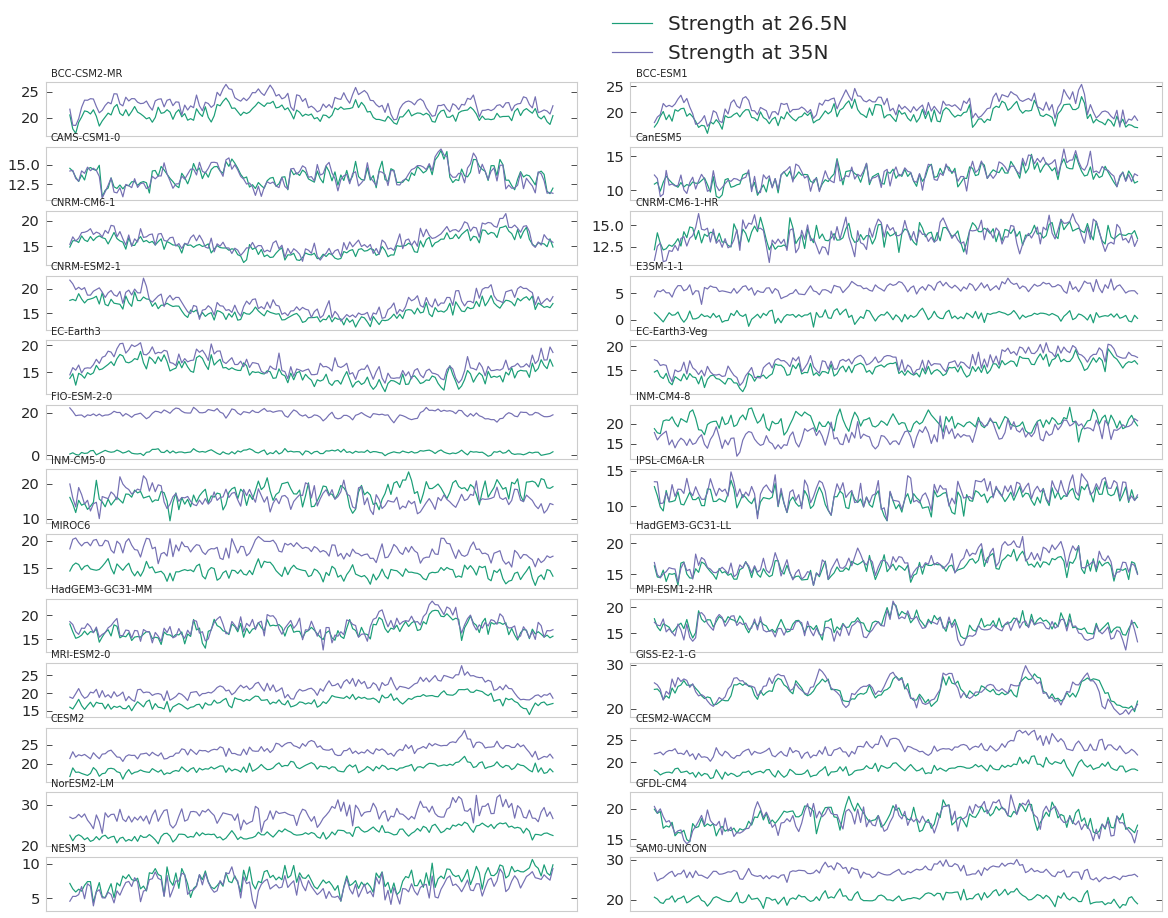

In [11]:
%matplotlib inline
fig = plt.figure(figsize=(20,20))
gs = fig.add_gridspec(17, 2)
ic = 0
for im, model in enumerate(models):
    if np.sum(np.nan_to_num(strn26[im,0,:])) != 0 :
        ax = fig.add_subplot(gs[int((ic-ic%2)/2),int(ic%2)])
        if ic==0:
            strn26[im,0,:].plot.line(x='year',color='C0',label='Strength at 26.5N')
            strn35[im,0,:].plot.line(x='year',color='C2',label='Strength at 35N')
            ax.legend(bbox_to_anchor=(1.05, 1.2), loc='lower left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False)
        else:
            strn26[im,0,:].plot.line(x='year',color='C0')
            strn35[im,0,:].plot.line(x='year',color='C2')
        ax.set_title('')
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.tick_params(axis='x', which='both',bottom=False,top=False,labelbottom=False, labelsize=fontsize)
        ax.text(0.01,1.1,model,transform=ax.transAxes,ma='left',color='k',fontsize=10)
        ic= ic+1
fig.patch.set_facecolor("white")
fig.subplots_adjust(hspace=0.2,wspace=0.1)
plt.show()

# Trend correlation - C18 plot

In [12]:
data2_c = pd.read_excel('caesar2021_Data_compilation.xlsx',sheet_name='Caesar et al. (2018)',skiprows=1)
oyear=data2_c['year']
oindex=data2_c['AMOC proxy [K]']
slope, intercept, r, p, se = linregress(oyear, oindex)
o_trend = slope*100

In [13]:
yrs = strn26.year.values
strn26_trend = np.zeros((34,10))
for imod in range(34):
    for iens in range(10):
        amc = np.nan_to_num(strn26.values[imod,iens,:])
        slope, intercept, r, p, se = linregress(yrs, amc)
        strn26_trend[imod,iens]=slope*100 # trend of Sv/century
index_trend = np.zeros((34,10))
for imod in range(34):
    for iens in range(10):
        idx = np.nan_to_num(index.values[imod,iens,:])
        slope, intercept, r, p, se = linregress(yrs, idx)
        index_trend[imod,iens]=slope*100 # trend of Sv/century
strn35_trend = np.zeros((34,10))
for imod in range(34):
    for iens in range(10):
        amc = np.nan_to_num(strn35.values[imod,iens,:])
        slope, intercept, r, p, se = linregress(yrs, amc)
        strn35_trend[imod,iens]=slope*100 # trend of Sv/century

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


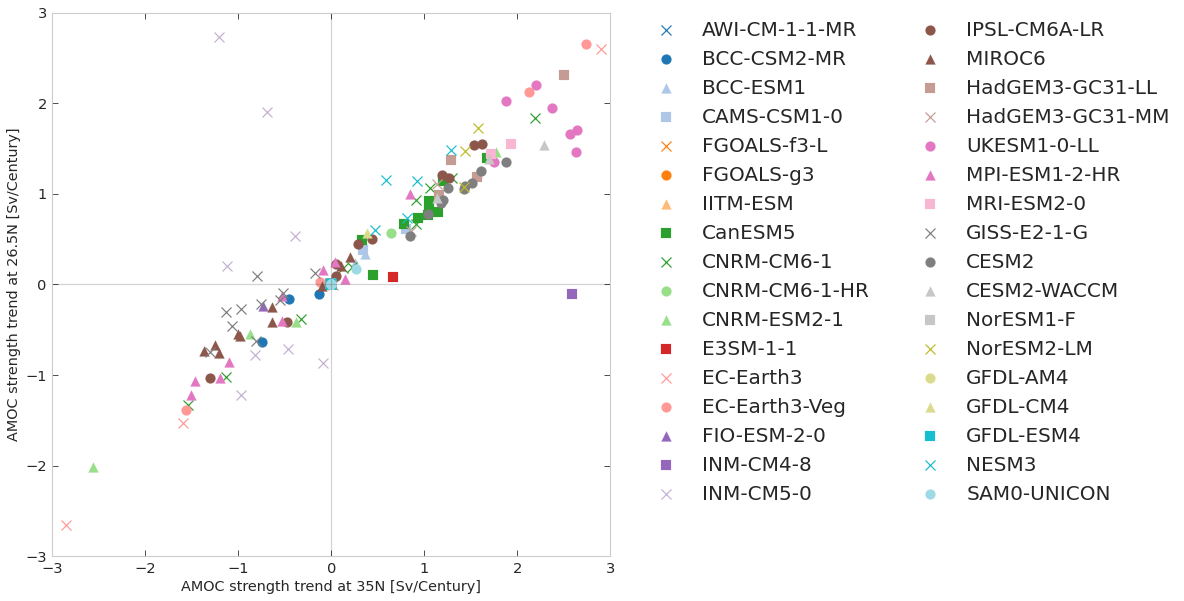

In [14]:
cmap = plt.get_cmap('tab20')
color_list = [cmap(i/34) for i in np.arange(0,34)]
markers = ['x','o','^','s']

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for i, mod in enumerate(models):
    marker = markers[i%4]
    col = color_list[i]
    plt.scatter(strn35_trend[i],strn26_trend[i],color=col,label=mod,marker=marker,s=100)
ax.set_ylim(-3,3)
ax.set_xlim(-3,3)
plt.hlines(0,-10,10,color='k',alpha=0.2)
plt.vlines(0,-10,10,color='k',alpha=0.2)
# ax.legend(bbox_to_anchor=(0.01, 0.98), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=2)
plt.xlabel('AMOC strength trend at 35N [Sv/Century]')
plt.ylabel('AMOC strength trend at 26.5N [Sv/Century]')
fig.patch.set_facecolor("white")
plt.show()

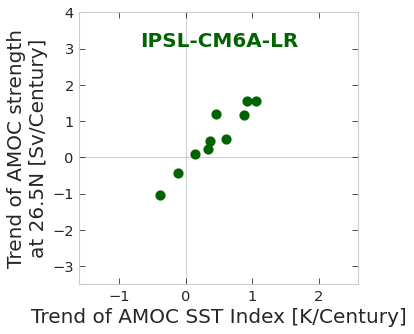

In [16]:
cmap = plt.get_cmap('tab20')
color_list = [cmap(i/34) for i in np.arange(0,34)]
markers = ['x','o','^','s']

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
mod = 'IPSL-CM6A-LR'
i = 17
col = 'darkgreen'
plt.scatter(index_trend[i],strn26_trend[i],color=col,label=mod,marker=marker,s=100)
ax.set_title(mod,color=col,y=0.85,fontweight='bold',fontsize=20)
ax.set_ylim(-3.5,4)
ax.set_xlim(-1.6,2.6)
plt.hlines(0,-10,10,color='k',alpha=0.2)
plt.vlines(0,-10,10,color='k',alpha=0.2)
plt.xlabel('Trend of AMOC SST Index [K/Century]',fontsize=20)
plt.ylabel('Trend of AMOC strength\nat 26.5N [Sv/Century]',fontsize=20)
fig.patch.set_facecolor("white")
plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


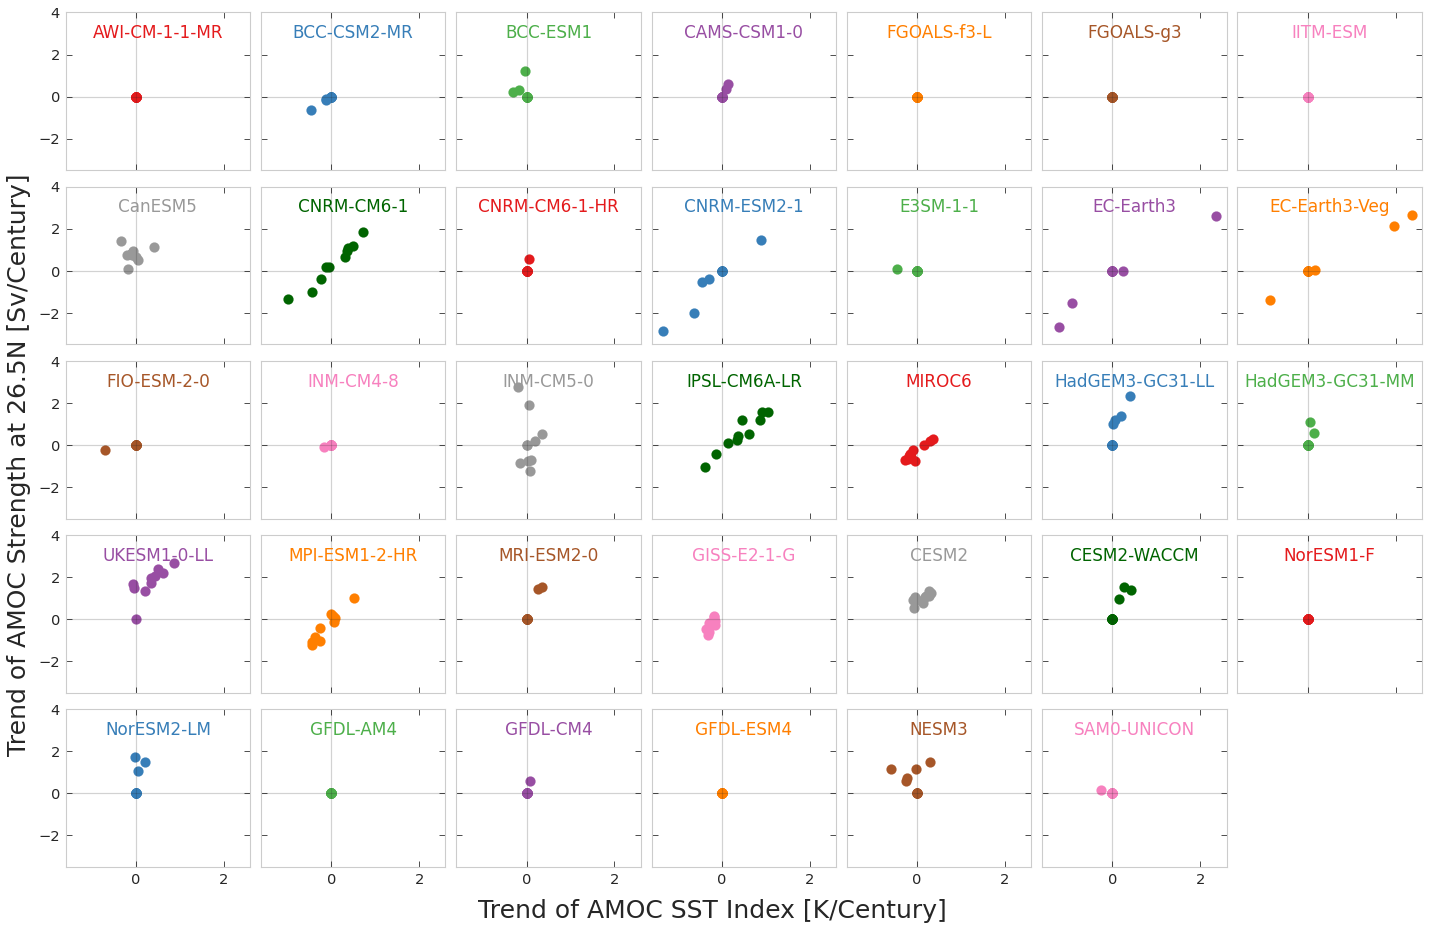

In [17]:
cmap = plt.get_cmap('tab20')
color_list = [cmap(i/19) for i in np.arange(0,20)]+[cmap(i/20) for i in np.arange(0,20)]
color_list = np.tile(['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#b15928'],4)
color_list = np.tile(['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#a65628','#f781bf','#999999','darkgreen'],10)
markers = ['x','o','h','s']

fig, axs = plt.subplots(5,7,figsize = (20,13),facecolor='white')
for i, ax in enumerate(axs.flatten()):
    if i<=33:
        mod = models[i]
        marker = markers[i%4]
        marker='o'
        col = color_list[i]
        ax.scatter(index_trend[i],strn26_trend[i],color=col,label=mod,marker=marker,s=100)
        ax.set_ylim(-3.5,4)
        ax.set_xlim(-1.6,2.6)
        ax.hlines(0,-10,10,color='k',alpha=0.2)
        ax.vlines(0,-10,10,color='k',alpha=0.2)
        ax.set_title(mod,color=col,y=0.8)
    if not ((i==0) or (i==7) or (i==14) or (i==21) or (i==28)):
        ax.tick_params(axis='y', which='both',labelleft=False, labelsize=fontsize)
    if not (i>=28): 
        ax.tick_params(axis='x', which='both',bottom=True,top=True,labelbottom=False, labelsize=fontsize)
    if i==34:
        ax.axis('off')
            
# ax.ylabel('AMOC strength trend at 26.5N [Sv/Century]')
# ax.xlabel('AMOC index trend [K/Century]')
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=2)
fig.supxlabel('Trend of AMOC SST Index [K/Century]',fontsize=25)
fig.supylabel('Trend of AMOC Strength at 26.5N [Sv/Century]',fontsize=25,x=0.01)
fig.tight_layout()
# ax.legend(bbox_to_anchor=(-1.3, -0.1), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=5)
plt.show()

# oscillations

In [41]:
with open('/p/tmp/mayayami/amoc26N.pkl', 'rb') as f:
    amoc = pickle.load(f)

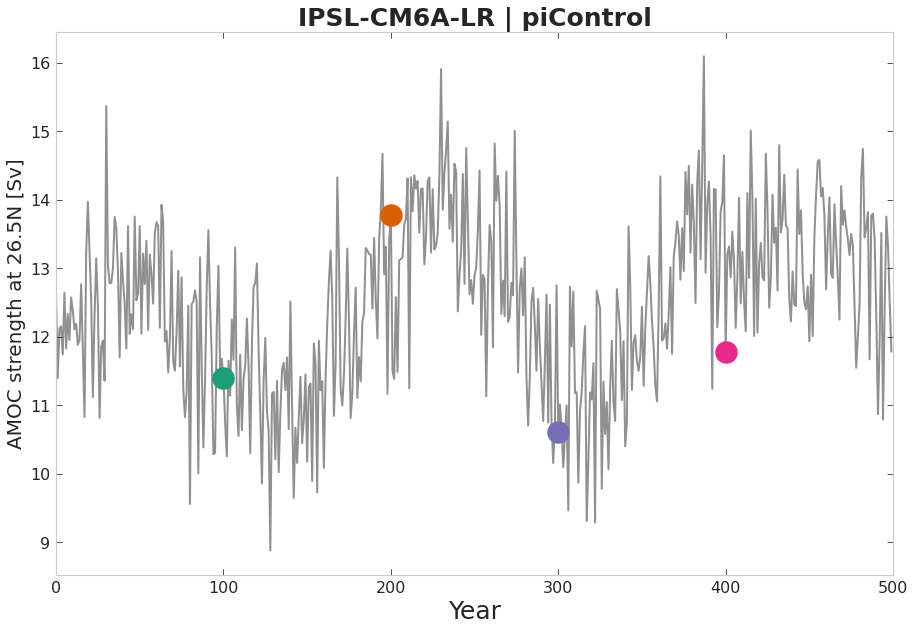

In [66]:
mss = ['IPSL-CM6A-LR','CESM2','EC-Earth3','HadGEM3-GC3-1MM']
mss = ['IPSL-CM6A-LR','CESM2','EC-Earth3','CanESM5']
m = 'CESM2'

model_colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3']
model_colors2 = ['#a6d854','#ffd92f','#b3b3b3','#e5c494']
fig, ax = plt.subplots(1,1,figsize = (15,10))
m = mss[0]
ax.plot(amoc[m]['con'],color='k',lw=2,alpha=0.5)
for i, t in enumerate([100,200,300,400]):
    plt.scatter(t,amoc[m]['con'][t],s=500,zorder=20)
ax.set_title('{} | piControl'.format(m),fontweight='bold',fontsize=25)
ax.set_xlim(0,500)
# ax.set_ylim(8,22)
ax.tick_params(axis='x', which='both',labelbottom=False, labelsize=fontsize)
ax.tick_params(axis='y', which='both',labelleft=False, labelsize=fontsize)
ax.set_ylabel('AMOC strength at 26.5N [Sv]',fontsize=20)
ax.tick_params(axis='y', which='both',labelleft=True, labelsize=fontsize)
ax.set_xlabel('Year',fontsize=25)
ax.tick_params(axis='x', which='both',labelbottom=True, labelsize=fontsize)
fig.subplots_adjust(wspace=0.05)
plt.show()

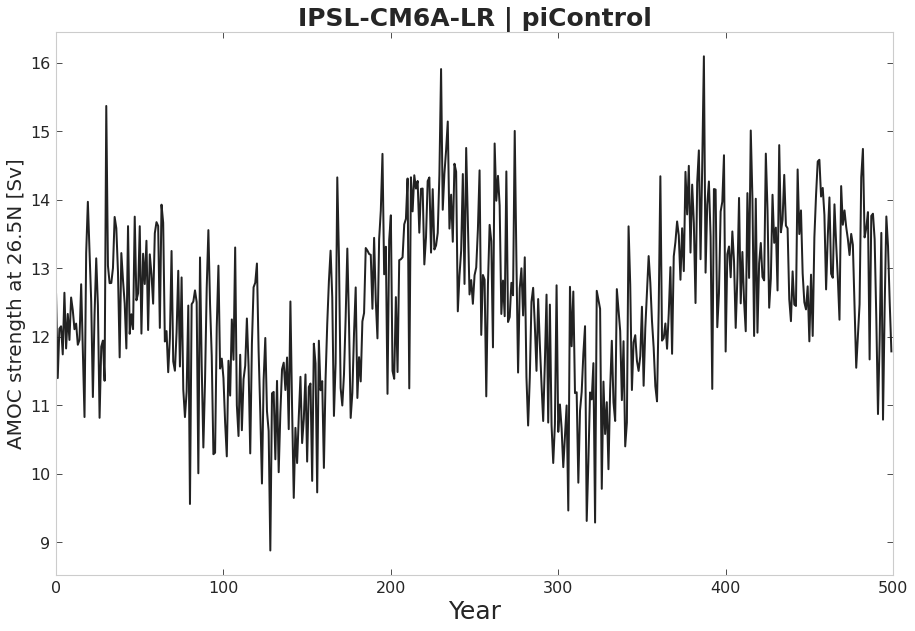

In [54]:
mss = ['IPSL-CM6A-LR','CESM2','EC-Earth3','HadGEM3-GC3-1MM']
mss = ['IPSL-CM6A-LR','CESM2','EC-Earth3','CanESM5']
m = 'CESM2'

model_colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3']
model_colors2 = ['#a6d854','#ffd92f','#b3b3b3','#e5c494']
fig, ax = plt.subplots(1,1,figsize = (15,10))
m = mss[0]
ax.plot(amoc[m]['con'],color='k',lw=2)
ax.set_title('{} | piControl'.format(m),fontweight='bold',fontsize=25)
ax.set_xlim(0,500)
# ax.set_ylim(8,22)
ax.tick_params(axis='x', which='both',labelbottom=False, labelsize=fontsize)
ax.tick_params(axis='y', which='both',labelleft=False, labelsize=fontsize)
ax.set_ylabel('AMOC strength at 26.5N [Sv]',fontsize=20)
ax.tick_params(axis='y', which='both',labelleft=True, labelsize=fontsize)
ax.set_xlabel('Year',fontsize=25)
ax.tick_params(axis='x', which='both',labelbottom=True, labelsize=fontsize)
fig.subplots_adjust(wspace=0.05)
plt.show()

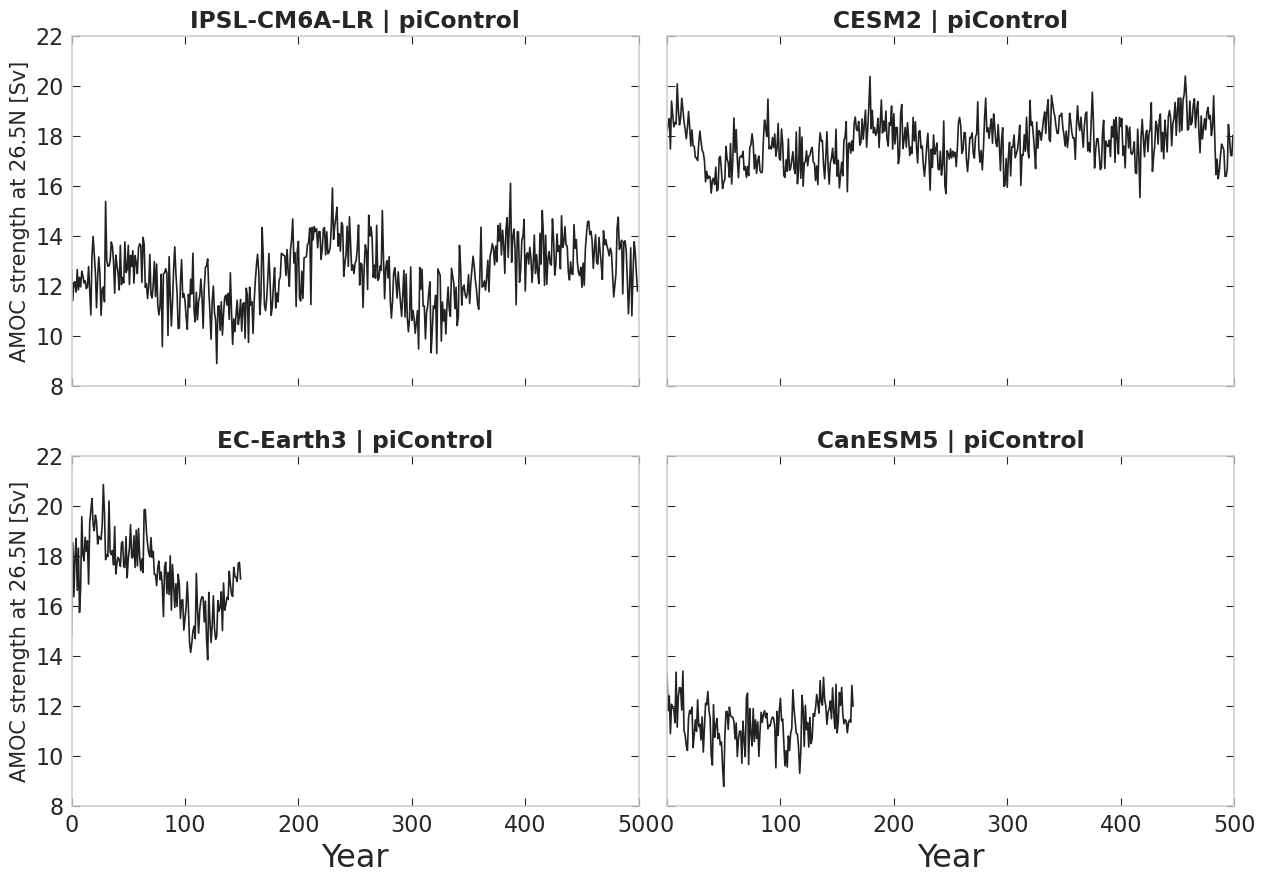

In [42]:
mss = ['IPSL-CM6A-LR','CESM2','EC-Earth3','HadGEM3-GC3-1MM']
mss = ['IPSL-CM6A-LR','CESM2','EC-Earth3','CanESM5']
m = 'CESM2'

model_colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3']
model_colors2 = ['#a6d854','#ffd92f','#b3b3b3','#e5c494']
fig, axs = plt.subplots(2,2,figsize = (15,10))
for i, ax in enumerate(axs.flatten()):
    m = mss[i]
    ax.plot(amoc[m]['con'],'k')
    ax.set_title('{} | piControl'.format(m),fontweight='bold')
    ax.set_xlim(0,500)
    ax.set_ylim(8,22)
    ax.tick_params(axis='x', which='both',labelbottom=False, labelsize=fontsize)
    ax.tick_params(axis='y', which='both',labelleft=False, labelsize=fontsize)
    if (i==0) | (i==2):
        ax.set_ylabel('AMOC strength at 26.5N [Sv]',fontsize=15)
        ax.tick_params(axis='y', which='both',labelleft=True, labelsize=fontsize)
    if i>=2:
        ax.set_xlabel('Year')
        ax.tick_params(axis='x', which='both',labelbottom=True, labelsize=fontsize)
fig.subplots_adjust(wspace=0.05)
plt.show()

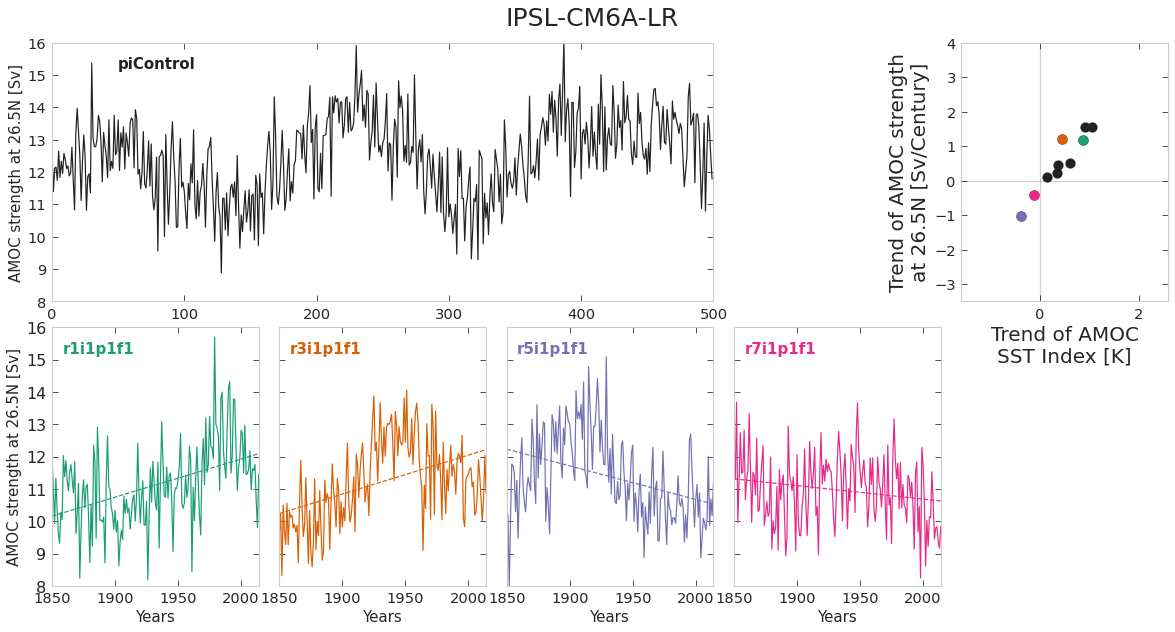

In [98]:
# fig = plt.figure(figsize=(15,5))
# ax = fig.add_subplot(111)
colorss = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']
model = 'CESM2'
model = 'IPSL-CM6A-LR'
mod = 'IPSL-CM6A-LR'
colorss = ['#1b9e77','#d95f02','#7570b3','#e7298a']
# model = 'HadGEM3-GC31-MM'
# model = 'CanESM5'
# model = 'EC-Earth3'
# model = 'CNRM-CM6-1'
# for modls in [models[0:17],models[17:]]:
fig = plt.figure(figsize=(20,10))
# gs = fig.add_gridspec(5, 3,width_ratios=(1,0.5,1.5))
gs = fig.add_gridspec(2,5)


ax1 = fig.add_subplot(gs[0,-1])
i = 17
col = 'k'
plt.scatter(index_trend[i],strn26_trend[i],color=col,label=mod,marker=marker,s=100)
# ax1.set_title(mod,color=col,y=0.85,fontweight='bold',fontsize=20)
ax1.set_ylim(-3.5,4)
ax1.set_xlim(-1.6,2.6)
ax1.hlines(0,-10,10,color='k',alpha=0.2)
ax1.vlines(0,-10,10,color='k',alpha=0.2)
ax1.set_xlabel('Trend of AMOC\nSST Index [K]',fontsize=20)
ax1.set_ylabel('Trend of AMOC strength\nat 26.5N [Sv/Century]',fontsize=20)

ax = fig.add_subplot(gs[0,:-2])
ax.plot(amoc[mod]['con'],'k')
ax.text(0.1,0.9,'piControl',transform=ax.transAxes,ma='left',color=col,fontsize=15,fontweight='bold')
ax.set_xlim(0,500)
#     ax.set_ylim(0,22)
ax.set_xlabel('Years')
ax.set_ylabel('AMOC strength at 26.5N [Sv]',fontsize=15)
ax.set_ylim(8,16)

for j, iens in enumerate([1,3,5,7]):
    ax = fig.add_subplot(gs[1,j])
    col = 'C0'
    col = colorss[j]
    ax1.scatter(index_trend[i,iens],strn26_trend[i,iens],color=col,label=mod,marker=marker,s=100)
    amc = np.nan_to_num(strn26.sel(models=model).isel(ensemble_members=iens).values)
    slope, intercept, r, p, se = linregress(yrs, amc)
    strn26.sel(models=model).isel(ensemble_members=iens).plot(color=col,ax=ax)
    ax.plot(yrs,slope*yrs+intercept,color=col,linestyle='--')
    ax.set_title('')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim(8,16)
    ax.text(0.05,0.9,'r{}i1p1f1'.format(iens),transform=ax.transAxes,ma='left',color=col,fontsize=15,fontweight='bold')
#         ax.set_ylim(7,17)
#         ax.set_ylim(15,22)
#         ax.set_ylim(8.5,15.5)
#         ax.set_ylim(strn26.sel(models=model).min(),strn26.sel(models=model).max())
    ax.set_xlim(1850,2014)
    ax.tick_params(axis='y', which='both',labelleft=False, labelsize=fontsize)
    if j==0:
        ax.tick_params(axis='y', which='both',labelleft=True, labelsize=fontsize)
        ax.set_ylabel('AMOC strength at 26.5N [Sv]',fontsize=15)
    ax.set_xlabel('Years',fontsize=15)

fig.subplots_adjust(wspace=0.1,hspace=0.1)
fig.suptitle(model,fontsize=25,y=0.93)
plt.show()

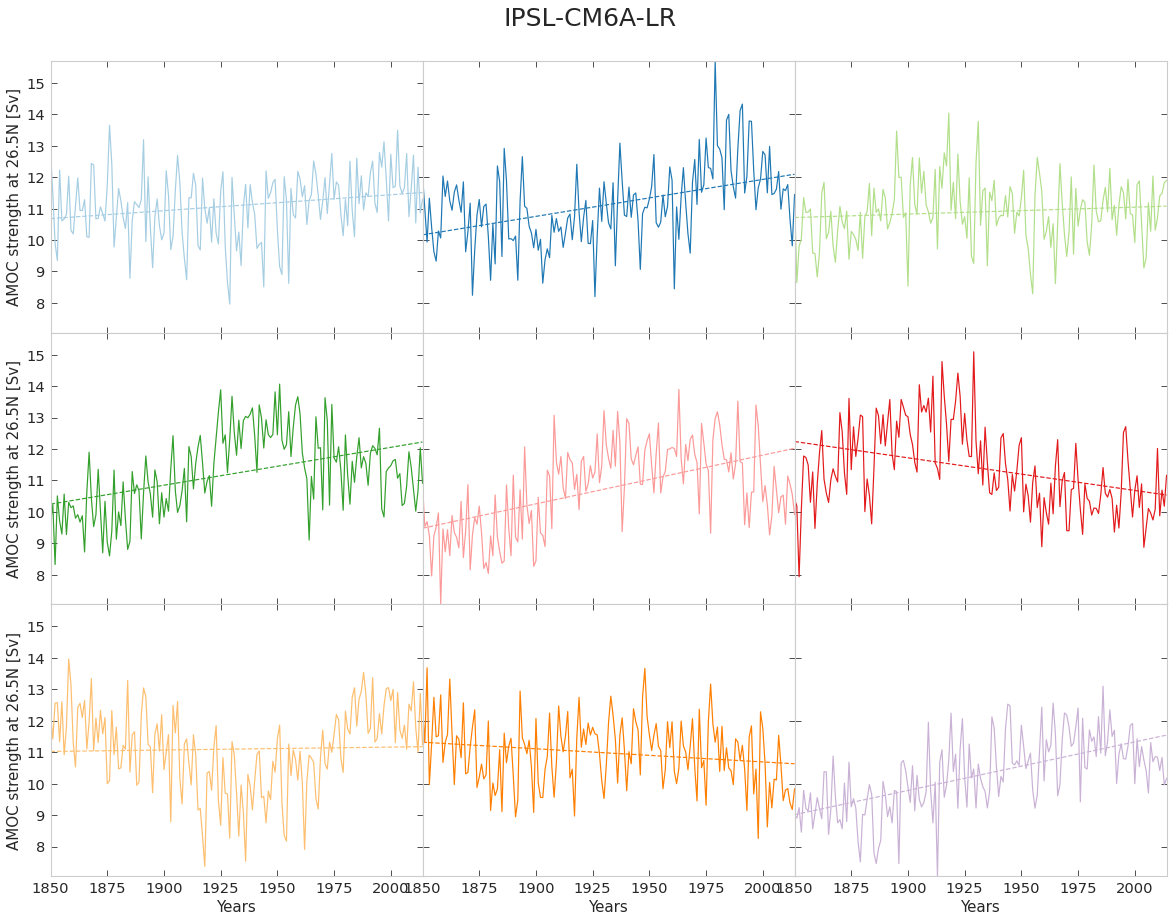

In [80]:
# fig = plt.figure(figsize=(15,5))
# ax = fig.add_subplot(111)
colorss = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']
model = 'CESM2'
model = 'IPSL-CM6A-LR'
# model = 'HadGEM3-GC31-MM'
# model = 'CanESM5'
# model = 'EC-Earth3'
# model = 'CNRM-CM6-1'
fig, axs = plt.subplots(3,3,figsize = (20,15),facecolor='white')
for iens, ax in enumerate(axs.flatten()):
# for iens in range(5):
    col = 'C0'
    col = colorss[iens]
    try:
        amc = np.nan_to_num(strn26.sel(models=model).isel(ensemble_members=iens).values)
        slope, intercept, r, p, se = linregress(yrs, amc)
        strn26.sel(models=model).isel(ensemble_members=iens).plot(color=col,ax=ax)
        ax.plot(yrs,slope*yrs+intercept,color=col,linestyle='--')
        ax.set_title('')
        ax.set_xlabel('')
        ax.set_ylabel('')
#         ax.set_ylim(7,17)
#         ax.set_ylim(15,22)
#         ax.set_ylim(8.5,15.5)
        ax.set_ylim(strn26.sel(models=model).min(),strn26.sel(models=model).max())
        ax.set_xlim(1850,2014)
        ax.set_ylabel('AMOC strength at 26.5N [Sv]',fontsize=15)
        ax.set_xlabel('Years',fontsize=15)
        if not ((iens==0) or (iens==3) or (iens==6)):
            ax.tick_params(axis='y', which='both',labelleft=False, labelsize=fontsize)
            ax.set_ylabel('')
        if not (iens>=6):
            ax.tick_params(axis='x', which='both',bottom=True,top=True,labelbottom=False, labelsize=fontsize)
            ax.set_xlabel('')
    except:
        if not ((iens==0) or (iens==3) or (iens==6)):
            ax.tick_params(axis='y', which='both',labelleft=False, labelsize=fontsize)
            ax.set_ylabel('')
        if not (iens>=6):
            ax.tick_params(axis='x', which='both',bottom=True,top=True,labelbottom=False, labelsize=fontsize)
            ax.set_xlabel('')
fig.subplots_adjust(wspace=0,hspace=0)
fig.suptitle(model,fontsize=25,y=0.93)
plt.show()

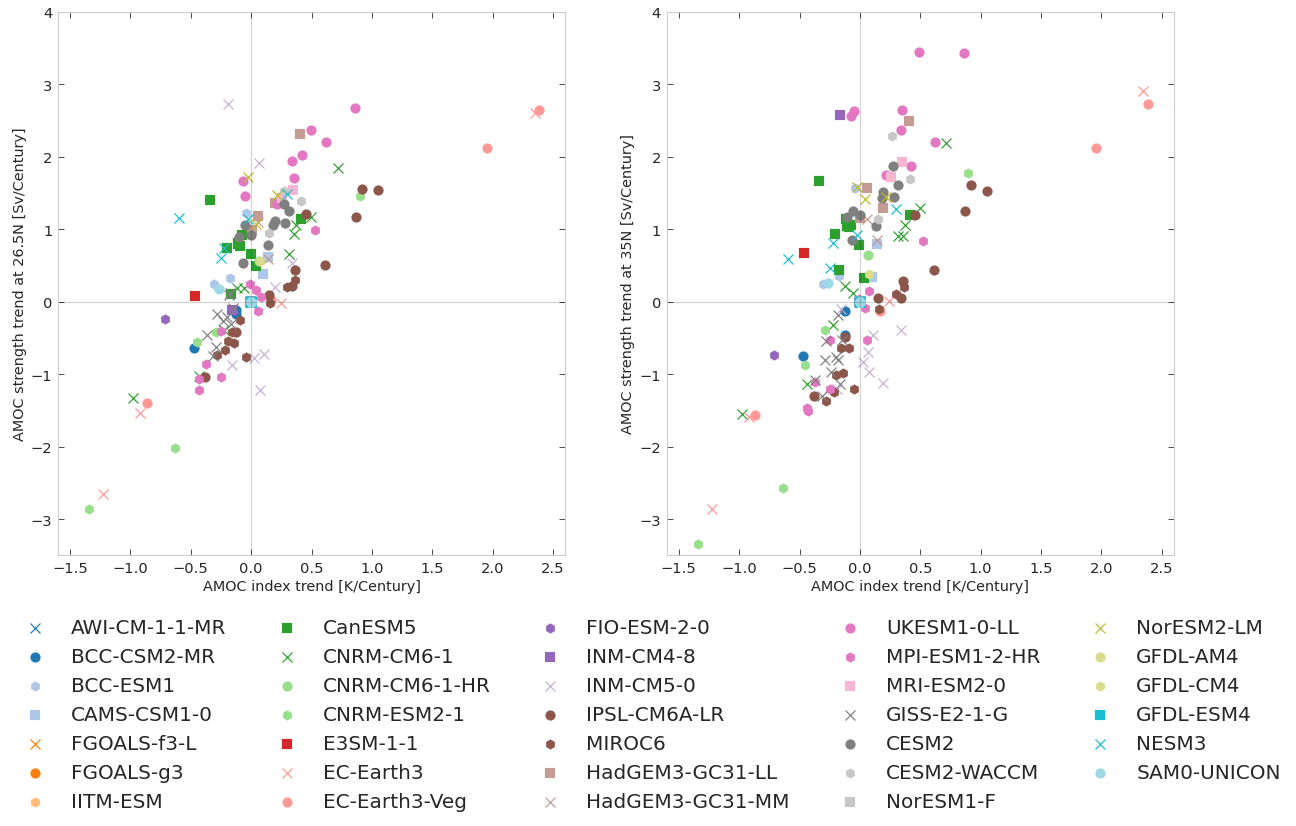

In [18]:
cmap = plt.get_cmap('tab20')
color_list = [cmap(i/34) for i in np.arange(0,34)]
markers = ['x','o','h','s']

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121)
for i, mod in enumerate(models):
    marker = markers[i%4]
    col = color_list[i]
    plt.scatter(index_trend[i],strn26_trend[i],color=col,label=mod,marker=marker,s=100)
ax.set_ylim(-3.5,4)
ax.set_xlim(-1.6,2.6)
plt.hlines(0,-10,10,color='k',alpha=0.2)
plt.vlines(0,-10,10,color='k',alpha=0.2)
plt.ylabel('AMOC strength trend at 26.5N [Sv/Century]')
plt.xlabel('AMOC index trend [K/Century]')
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=2)

ax = fig.add_subplot(122)
for i, mod in enumerate(models):
    marker = markers[i%4]
    col = color_list[i]
    plt.scatter(index_trend[i],strn35_trend[i],color=col,label=mod,marker=marker,s=100)
ax.set_ylim(-3.5,4)
ax.set_xlim(-1.6,2.6)
plt.hlines(0,-10,10,color='k',alpha=0.2)
plt.vlines(0,-10,10,color='k',alpha=0.2)
plt.ylabel('AMOC strength trend at 35N [Sv/Century]')
plt.xlabel('AMOC index trend [K/Century]')
ax.legend(bbox_to_anchor=(-1.3, -0.1), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=5)
plt.show()

In [18]:
data2_c = pd.read_excel('caesar2021_Data_compilation.xlsx',sheet_name='Caesar et al. (2018)',skiprows=1)
oyear=data2_c['year']
oindex=data2_c['AMOC proxy [K]']
otrend, intercept, r, p, se = linregress(oyear, oindex)

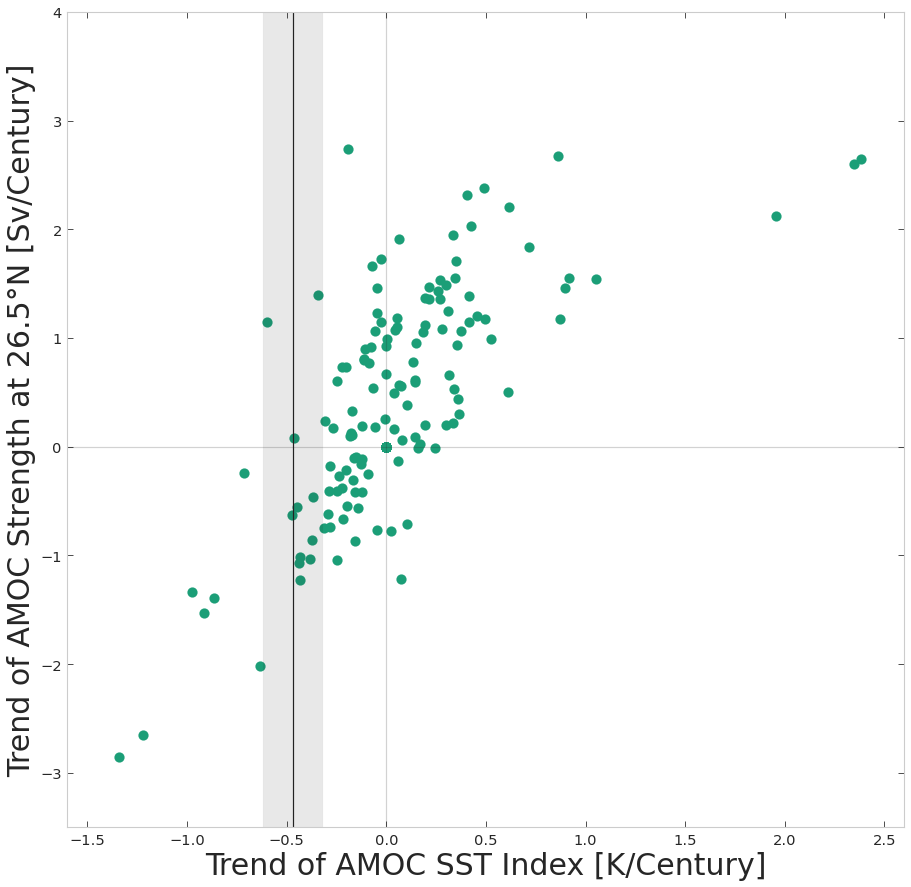

In [28]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
plt.scatter(index_trend,strn26_trend,s=100)
slope, intercept, r, p, se = linregress(index_trend.flatten(), strn26_trend.flatten())
xx = np.linspace(-2,3,100)
# plt.plot(xx,intercept+xx*slope,color='C1',label='Slope = {:.2f}'.format(slope)+' Sv K$^{-1}$'+'\nR = {:.2f}'.format(r, p))
ax.set_ylim(-3.5,4)
ax.set_xlim(-1.6,2.6)
plt.hlines(0,-10,10,color='k',alpha=0.2)
plt.vlines(0,-10,10,color='k',alpha=0.2)
plt.vlines(o_trend,-10,10,color='k',label='HadISST')
plt.fill_betweenx([-10,10],o_trend-0.15,o_trend+0.15,color='k',alpha=0.1)
# ax.legend(bbox_to_anchor=(0.45, 0.25), loc='upper left', borderaxespad=0., fontsize=15,fancybox=False,frameon=False)
plt.xlabel('Trend of AMOC SST Index [K/Century]',fontsize=30,y=-0.1)
plt.ylabel('Trend of AMOC Strength at 26.5°N [Sv/Century]',fontsize=30,x=0.01)
# ax.text(0.48,0.28,'CMIP6 historical runs',transform=ax.transAxes,ma='left',color='C0',fontsize=15,fontweight='bold')

fig.patch.set_facecolor("white")
plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


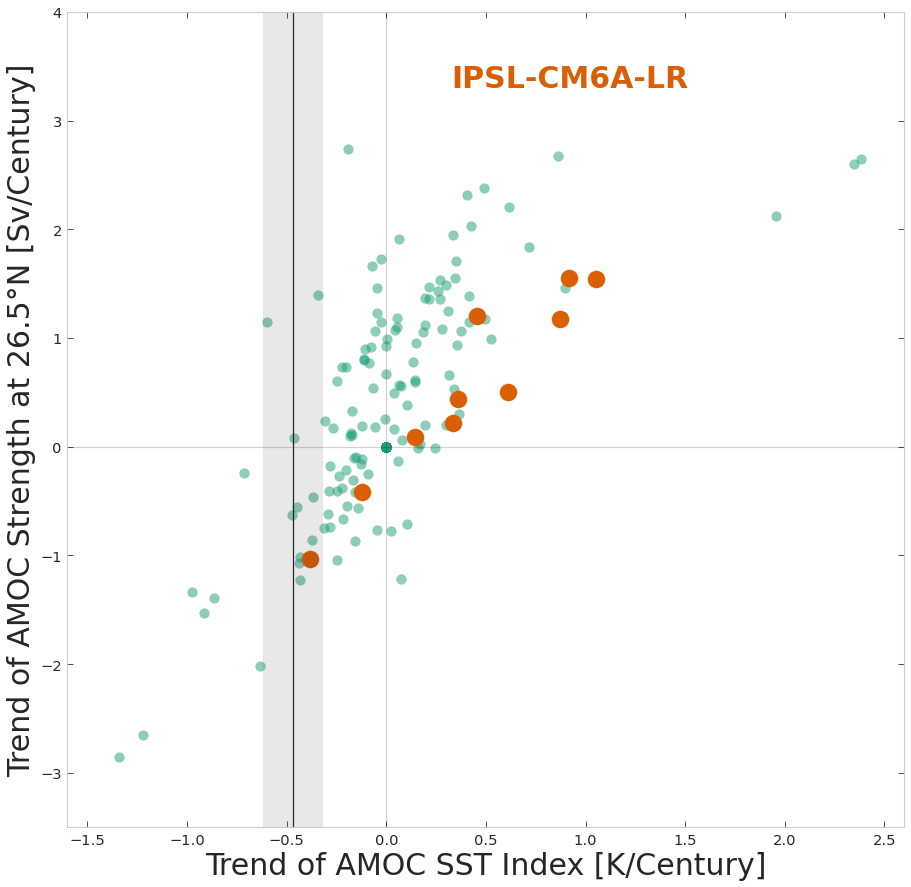

In [30]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
i=17
mod = 'IPSL-CM6A-LR'
col='C1'
plt.scatter(index_trend,strn26_trend,alpha=0.5,s=100)
plt.scatter(index_trend[i],strn26_trend[i],color=col,marker=marker,s=300)
ax.set_ylim(-3.5,4)
ax.set_xlim(-1.6,2.6)
plt.hlines(0,-10,10,color='k',alpha=0.2)
plt.vlines(0,-10,10,color='k',alpha=0.2)
plt.vlines(o_trend,-10,10,color='k',label='HadISST')
ax.set_title(mod,color=col,y=0.9,x=0.6,fontweight='bold',fontsize=30)
plt.fill_betweenx([-10,10],o_trend-0.15,o_trend+0.15,color='k',alpha=0.1)
# ax.legend(bbox_to_anchor=(0.45, 0.25), loc='upper left', borderaxespad=0., fontsize=15,fancybox=False,frameon=False)
plt.xlabel('Trend of AMOC SST Index [K/Century]',fontsize=30,y=-0.1)
plt.ylabel('Trend of AMOC Strength at 26.5°N [Sv/Century]',fontsize=30,x=0.01)
# ax.text(0.48,0.28,'CMIP6 historical runs',transform=ax.transAxes,ma='left',color='C0',fontsize=15,fontweight='bold')

fig.patch.set_facecolor("white")
plt.show()

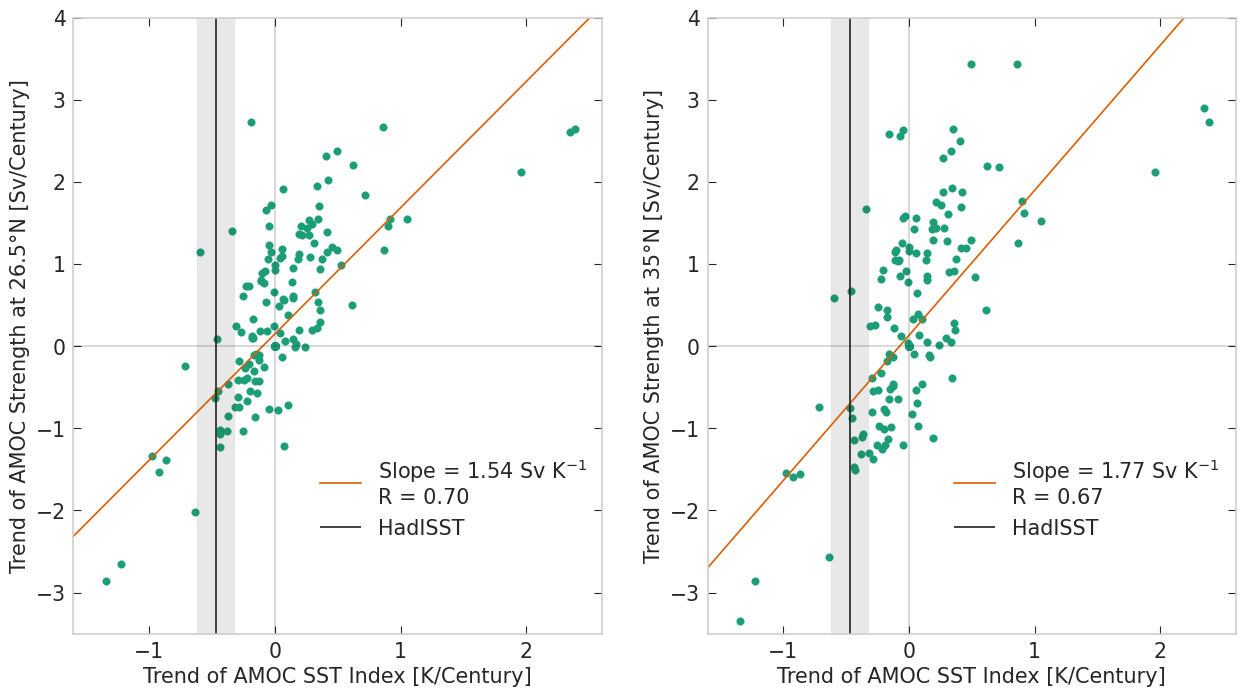

In [20]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(121)
plt.scatter(index_trend,strn26_trend)
slope, intercept, r, p, se = linregress(index_trend.flatten(), strn26_trend.flatten())
xx = np.linspace(-2,3,100)
plt.plot(xx,intercept+xx*slope,color='C1',label='Slope = {:.2f}'.format(slope)+' Sv K$^{-1}$'+'\nR = {:.2f}'.format(r, p))
ax.set_ylim(-3.5,4)
ax.set_xlim(-1.6,2.6)
plt.hlines(0,-10,10,color='k',alpha=0.2)
plt.vlines(0,-10,10,color='k',alpha=0.2)
plt.vlines(o_trend,-10,10,color='k',label='HadISST')
plt.fill_betweenx([-10,10],o_trend-0.15,o_trend+0.15,color='k',alpha=0.1)
ax.legend(bbox_to_anchor=(0.45, 0.3), loc='upper left', borderaxespad=0., fontsize=15,fancybox=False,frameon=False)
plt.xlabel('Trend of AMOC SST Index [K/Century]',fontsize=15)
plt.ylabel('Trend of AMOC Strength at 26.5°N [Sv/Century]',fontsize=15,x=0.01)

ax = fig.add_subplot(122)
plt.scatter(index_trend,strn35_trend)
slope, intercept, r, p, se = linregress(index_trend.flatten(), strn35_trend.flatten())
xx = np.linspace(-2,3,100)
plt.plot(xx,intercept+xx*slope,color='C1',label='Slope = {:.2f}'.format(slope)+' Sv K$^{-1}$'+'\nR = {:.2f}'.format(r))
ax.set_ylim(-3.5,4)
ax.set_xlim(-1.6,2.6)
# ax.set_xlim(-1,1)
plt.hlines(0,-10,10,color='k',alpha=0.2)
plt.vlines(0,-10,10,color='k',alpha=0.2)
plt.vlines(o_trend,-10,10,color='k',label='HadISST')
plt.fill_betweenx([-10,10],o_trend-0.15,o_trend+0.15,color='k',alpha=0.1)
ax.legend(bbox_to_anchor=(0.45, 0.3), loc='upper left', borderaxespad=0., fontsize=15,fancybox=False,frameon=False)
plt.xlabel('Trend of AMOC SST Index [K/Century]',fontsize=15)
plt.ylabel('Trend of AMOC Strength at 35°N [Sv/Century]',fontsize=15,x=0.01)
fig.patch.set_facecolor("white")
plt.show()

In [22]:
def get_period_trends(miny,maxy):
    strn26_trend = np.zeros((34,10))
    yrs = strn26.where(strn26.year>=miny,drop=True).where(strn26.year<=maxy,drop=True).year.values
    for imod in range(34):
        for iens in range(10):
            amc = np.nan_to_num(strn26.where(strn26.year>=miny,drop=True).where(strn26.year<=maxy,drop=True).values[imod,iens,:])
            slope, intercept, r, p, se = linregress(yrs, amc)
            strn26_trend[imod,iens]=slope*100 # trend of Sv/century
    index_trend = np.zeros((34,10))
    for imod in range(34):
        for iens in range(10):
            idx = np.nan_to_num(index.where(index.year>=miny,drop=True).where(index.year<=maxy,drop=True).values[imod,iens,:])
            slope, intercept, r, p, se = linregress(yrs, idx)
            index_trend[imod,iens]=slope*100 # trend of Sv/century
    strn35_trend = np.zeros((34,10))
    for imod in range(34):
        for iens in range(10):
            amc = np.nan_to_num(strn35.where(strn35.year>=miny,drop=True).where(strn35.year<=maxy,drop=True).values[imod,iens,:])
            slope, intercept, r, p, se = linregress(yrs, amc)
            strn35_trend[imod,iens]=slope*100 # trend of Sv/century
    return strn26_trend, strn35_trend, index_trend

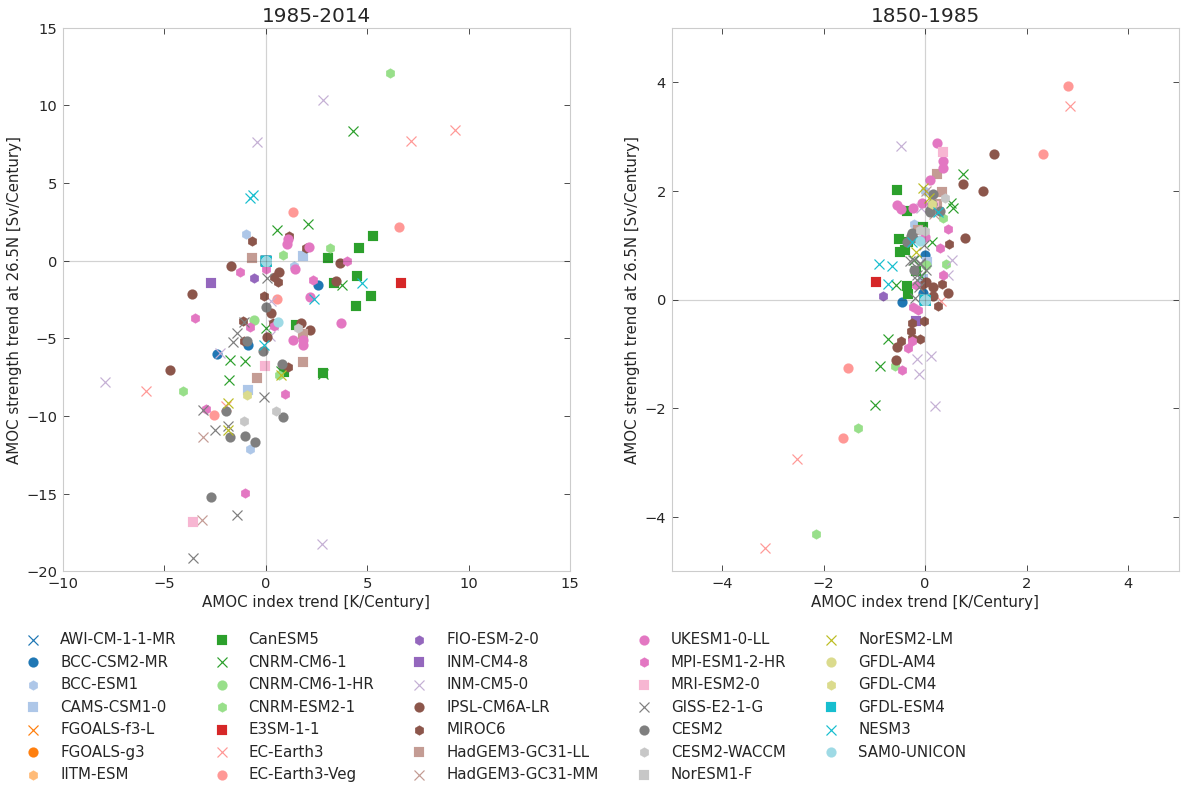

In [24]:
cmap = plt.get_cmap('tab20')
color_list = [cmap(i/34) for i in np.arange(0,34)]
markers = ['x','o','h','s']

fig = plt.figure(figsize=(20,10))

strn26_trend1, strn35_trend1, index_trend1 = get_period_trends(1985,2014)
ax = fig.add_subplot(121)
for i, mod in enumerate(models):
    marker = markers[i%4]
    col = color_list[i]
    plt.scatter(index_trend1[i],strn26_trend1[i],color=col,label=mod,marker=marker,s=100)
ax.set_ylim(-20,15)
ax.set_xlim(-10,15)
plt.hlines(0,-20,20,color='k',alpha=0.2)
plt.vlines(0,-20,20,color='k',alpha=0.2)
plt.ylabel('AMOC strength trend at 26.5N [Sv/Century]',fontsize=15)
plt.xlabel('AMOC index trend [K/Century]',fontsize=15)
ax.set_title('1985-2014',fontsize=20)

strn26_trend2, strn35_trend2, index_trend2 = get_period_trends(1850,1985)
ax = fig.add_subplot(122)
for i, mod in enumerate(models):
    marker = markers[i%4]
    col = color_list[i]
    plt.scatter(index_trend2[i],strn26_trend2[i],color=col,label=mod,marker=marker,s=100)
ax.set_ylim(-5,5)
ax.set_xlim(-5,5)
plt.hlines(0,-20,20,color='k',alpha=0.2)
plt.vlines(0,-20,20,color='k',alpha=0.2)
plt.ylabel('AMOC strength trend at 26.5N [Sv/Century]',fontsize=15)
plt.xlabel('AMOC index trend [K/Century]',fontsize=15)
ax.set_title('1850-1985',fontsize=20)

ax.legend(bbox_to_anchor=(-1.3, -0.1), loc='upper left', borderaxespad=0., fontsize=15,fancybox=False,frameon=False,ncol=5)

# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=15,fancybox=False,frameon=False,ncol=2)
plt.show()

# Timeseries correlation

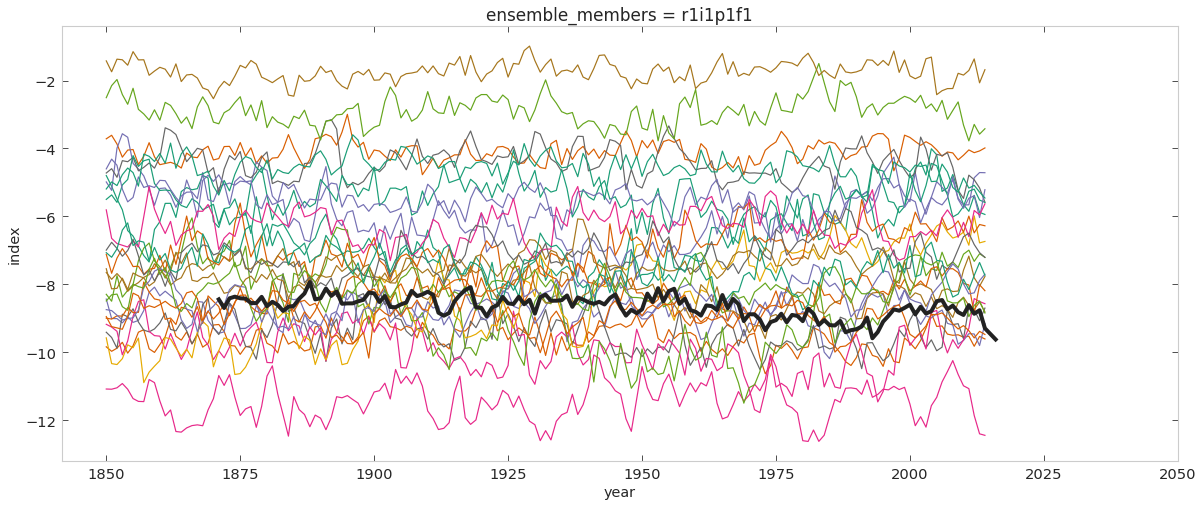

In [25]:
%matplotlib inline
fig = plt.figure(figsize = (20,8))
ax = fig.add_subplot(111)
data2_c = pd.read_excel('caesar2021_Data_compilation.xlsx',sheet_name='Caesar et al. (2018)',skiprows=1)
plt.plot(data2_c['year'],data2_c['AMOC proxy [K]'],color='k',label='Observations (HadISST)',lw=4,zorder=20)
# ax.legend(bbox_to_anchor=(1.05, 1.2), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False)
index[:,0,:].plot.line(x='year',add_legend=False)
ax.set_xlim(right=2050)
plt.show()

In [26]:
data2_c = pd.read_excel('caesar2021_Data_compilation.xlsx',sheet_name='Caesar et al. (2018)',skiprows=1)
oyear=data2_c['year']
oindex=data2_c['AMOC proxy [K]']
obs_index = xr.DataArray(
    data = oindex,
    dims = ['year'],
    coords = {'year':oyear},
    attrs = dict(
    description='Amoc index from Caesar 2018')
)
oindex = obs_index[:-2]

ds = xr.open_dataset('CMIP6_amoc.nc')
index = ds.index[:,:,21:]

## Raw

In [27]:
model26_corr = xr.corr(index,strn26,dim='year')

In [28]:
index_corr = xr.corr(index,oindex,dim='year')

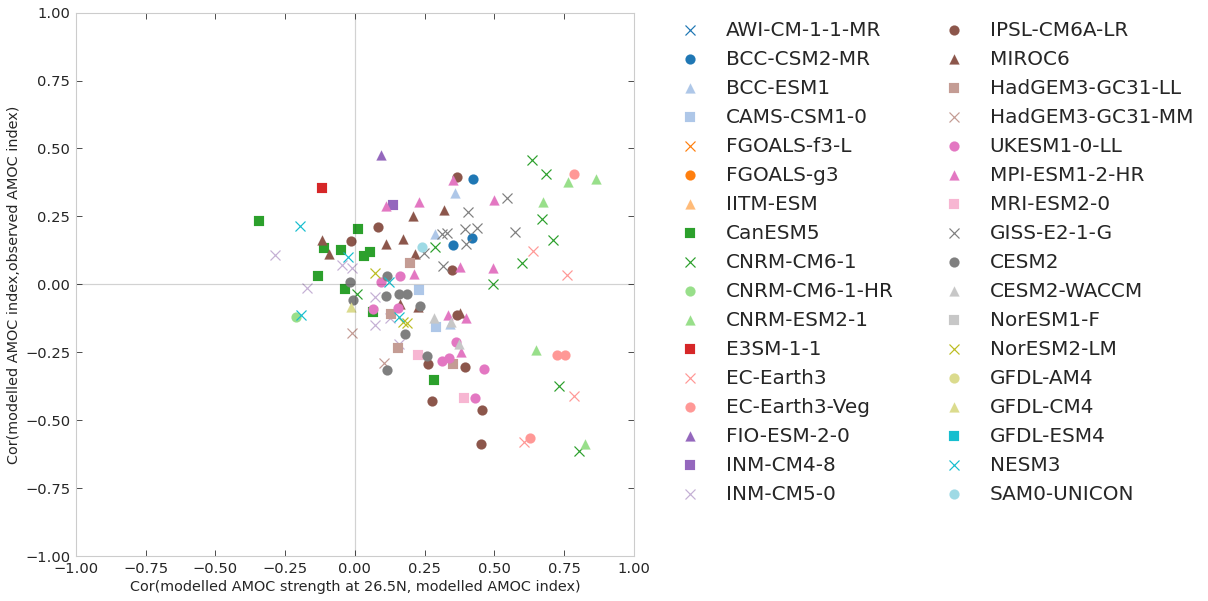

In [29]:
cmap = plt.get_cmap('tab20')
color_list = [cmap(i/34) for i in np.arange(0,34)]
markers = ['x','o','^','s']

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for i, mod in enumerate(models):
    marker = markers[i%4]
    col = color_list[i]
    plt.scatter(model26_corr[i],index_corr[i],color=col,label=mod,marker=marker,s=100)
# slope, intercept, r, p, se = linregress(index_trend.flatten(), strn_trend.flatten())
# xx = np.linspace(-2,3,100)
# plt.plot(xx,intercept+xx*slope,color='C1',label='Slope = {:.2f}'.format(slope)+' Sv K$^{-1}$'+'\nR = {:.2f}\nP < 1e-50'.format(r, p))
ax.set_ylim(-1,1)
ax.set_xlim(-1,1)
plt.hlines(0,-1,1,color='k',alpha=0.2)
plt.vlines(0,-1,1,color='k',alpha=0.2)
# ax.legend(bbox_to_anchor=(0.01, 0.98), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=2)
plt.ylabel('Cor(modelled AMOC index,observed AMOC index)')
plt.xlabel('Cor(modelled AMOC strength at 26.5N, modelled AMOC index)')
plt.show()

In [30]:
# cmap = plt.get_cmap('tab20')
# color_list = [cmap(i/34) for i in np.arange(0,34)]
# markers = ['x','o','^','s']

# for i, mod in enumerate(models):
    
#     fig = plt.figure(figsize=(5,5))
#     ax = fig.add_subplot(111)
#     marker = markers[i%4]
#     col = color_list[i]
#     plt.scatter(model26_corr[i],index_corr[i],color=col,label=mod,marker=marker,s=100)
# # slope, intercept, r, p, se = linregress(index_trend.flatten(), strn_trend.flatten())
# # xx = np.linspace(-2,3,100)
# # plt.plot(xx,intercept+xx*slope,color='C1',label='Slope = {:.2f}'.format(slope)+' Sv K$^{-1}$'+'\nR = {:.2f}\nP < 1e-50'.format(r, p))
#     ax.set_ylim(-1,1)
#     ax.set_xlim(-1,1)
#     plt.hlines(0,-1,1,color='k',alpha=0.2)
#     plt.vlines(0,-1,1,color='k',alpha=0.2)
# # ax.legend(bbox_to_anchor=(0.01, 0.98), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False)
#     ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=2)
#     plt.ylabel('Cor(modelled AMOC index,observed AMOC index)')
#     plt.xlabel('Cor(modelled AMOC strength, modelled AMOC index)')
#     plt.show()

## Simple decadal average

In [31]:
# dec_model26_corr = xr.corr(index.coarsen(year=10,boundary='trim').mean(),strn26.coarsen(year=10,boundary='trim').mean(),dim='year')
# dec_index_corr = xr.corr(index.coarsen(year=10,boundary='trim').mean(),oindex.coarsen(year=10,boundary='trim').mean(),dim='year')

In [32]:
# cmap = plt.get_cmap('tab20')
# color_list = [cmap(i/34) for i in np.arange(0,34)]
# markers = ['x','o','^','s']

# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111)
# for i, mod in enumerate(models):
#     marker = markers[i%4]
#     col = color_list[i]
#     plt.scatter(dec_model26_corr[i],dec_index_corr[i],color=col,label=mod,marker=marker,s=100)
# # slope, intercept, r, p, se = linregress(index_trend.flatten(), strn_trend.flatten())
# # xx = np.linspace(-2,3,100)
# # plt.plot(xx,intercept+xx*slope,color='C1',label='Slope = {:.2f}'.format(slope)+' Sv K$^{-1}$'+'\nR = {:.2f}\nP < 1e-50'.format(r, p))
# ax.set_ylim(-1,1)
# ax.set_xlim(-1,1)
# plt.hlines(0,-1,1,color='k',alpha=0.2)
# plt.vlines(0,-1,1,color='k',alpha=0.2)
# # ax.legend(bbox_to_anchor=(0.01, 0.98), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False)
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=2)
# plt.ylabel('Cor(modelled AMOC index,observed AMOC index)')
# plt.xlabel('Cor(modelled AMOC strength at 26.5N, modelled AMOC index)')
# plt.title('Correlations for DECADAL AVERAGE')
# plt.show()

## rolling decadal average

In [33]:
dec_model26_corr = xr.corr(index.rolling(year=10).mean(),strn26.rolling(year=10).mean(),dim='year')
dec_index_corr = xr.corr(index.rolling(year=10).mean(),oindex.rolling(year=10).mean(),dim='year')

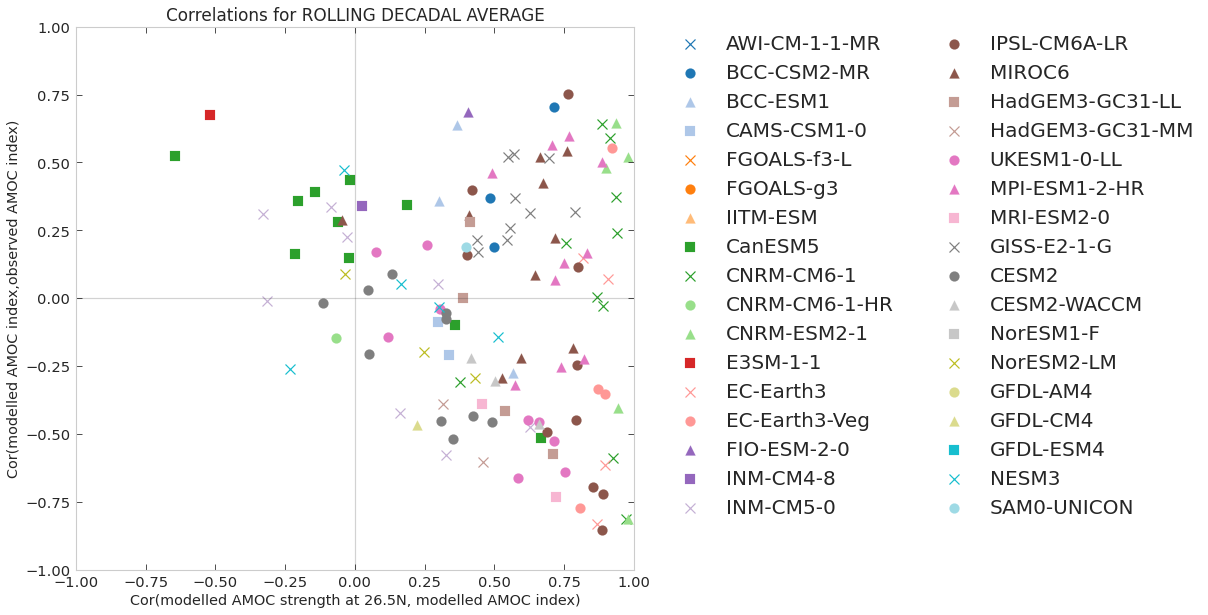

In [34]:
cmap = plt.get_cmap('tab20')
color_list = [cmap(i/34) for i in np.arange(0,34)]
markers = ['x','o','^','s']

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for i, mod in enumerate(models):
    marker = markers[i%4]
    col = color_list[i]
    plt.scatter(dec_model26_corr[i],dec_index_corr[i],color=col,label=mod,marker=marker,s=100)
# slope, intercept, r, p, se = linregress(index_trend.flatten(), strn_trend.flatten())
# xx = np.linspace(-2,3,100)
# plt.plot(xx,intercept+xx*slope,color='C1',label='Slope = {:.2f}'.format(slope)+' Sv K$^{-1}$'+'\nR = {:.2f}\nP < 1e-50'.format(r, p))
ax.set_ylim(-1,1)
ax.set_xlim(-1,1)
plt.hlines(0,-1,1,color='k',alpha=0.2)
plt.vlines(0,-1,1,color='k',alpha=0.2)
# ax.legend(bbox_to_anchor=(0.01, 0.98), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=2)
plt.ylabel('Cor(modelled AMOC index,observed AMOC index)')
plt.xlabel('Cor(modelled AMOC strength at 26.5N, modelled AMOC index)')
plt.title('Correlations for ROLLING DECADAL AVERAGE')
plt.show()

# Combinations

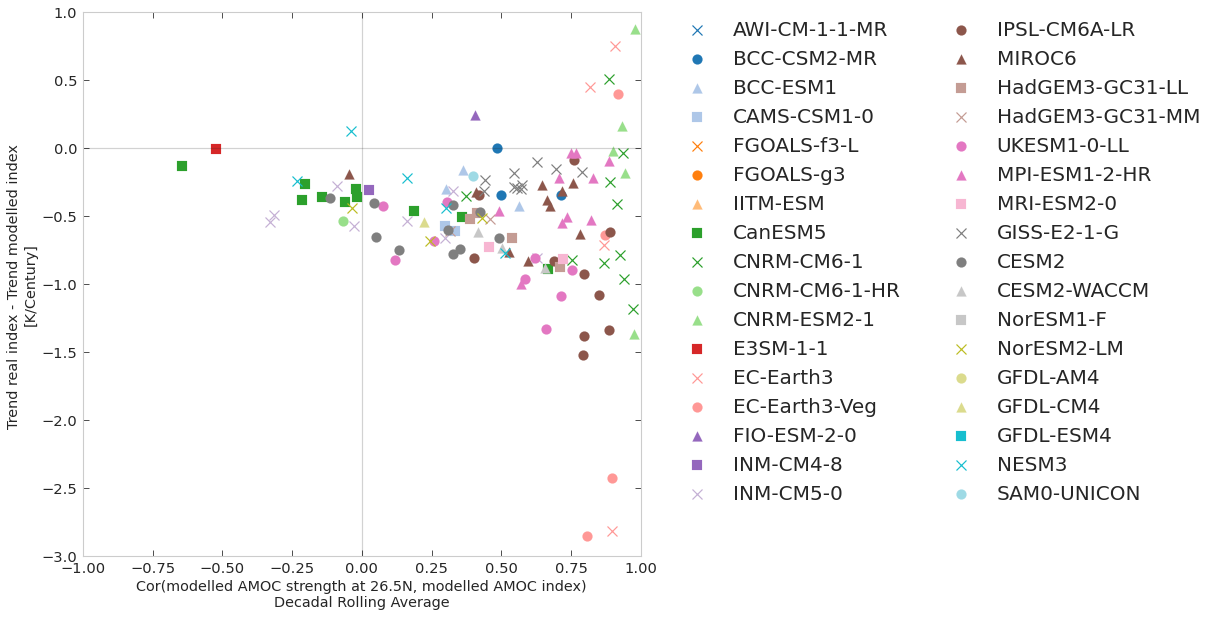

In [35]:
dec_model26_corr = xr.corr(index.rolling(year=10).mean(),strn26.rolling(year=10).mean(),dim='year')
index_trend_diff = o_trend - index_trend
cmap = plt.get_cmap('tab20')
color_list = [cmap(i/34) for i in np.arange(0,34)]
markers = ['x','o','^','s']

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for i, mod in enumerate(models):
    marker = markers[i%4]
    col = color_list[i]
    plt.scatter(dec_model26_corr[i],index_trend_diff[i],color=col,label=mod,marker=marker,s=100)
# slope, intercept, r, p, se = linregress(index_trend.flatten(), strn_trend.flatten())
# xx = np.linspace(-2,3,100)
# plt.plot(xx,intercept+xx*slope,color='C1',label='Slope = {:.2f}'.format(slope)+' Sv K$^{-1}$'+'\nR = {:.2f}\nP < 1e-50'.format(r, p))
ax.set_ylim(-3,1)
ax.set_xlim(-1,1)
plt.hlines(0,-13,1,color='k',alpha=0.2)
plt.vlines(0,-13,1,color='k',alpha=0.2)
# ax.legend(bbox_to_anchor=(0.01, 0.98), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=2)
plt.ylabel('Trend real index - Trend modelled index \n[K/Century]')
plt.xlabel('Cor(modelled AMOC strength at 26.5N, modelled AMOC index)\nDecadal Rolling Average')
plt.show()